## UPSC essay evaluation 

    State -> essay_text, CoT_feedback, DoA_feedback, lang_feedback, 
            final_feedback, individual_score -> [ of 3 items], final/avg_Score

    Output at the END -> final_feedback, individual_score -> [list of 3 items], final/avg_Score

    From each nodes 1. clarity of thought (CoT)
                    2. depth of analysis (DoA)
                    3. language
                we would retrieve the -> 1) text feedback
                                         2) score (0 - 10)

![](img/essay.png)

Concepts to use -> 
            
            1. Parallel Workflow
            2. Structured output (each internal nodes should provide an json data)
            3. Reducer function => explained ahead near usecase

                   

In [13]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Annotated
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import operator

In [3]:
load_dotenv()

True

In [33]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
)

In [34]:
# building a schema -> for the output
class EvaluationSchema(BaseModel):
    feedback: str = Field(description= 'Detailed feedback for the user')
    score: int = Field(description= 'Score out of 10', ge=0, le=10)

In [35]:
structured_model = model.with_structured_output(EvaluationSchema)

In [36]:
essay = """
    When I realized I was a punk rocker philosopher. One summer night, my friend took me to an underground hardcore punk rock show. It was inside a small abandoned church. After the show, I met and became a part of this small community. Many were lost and on a constant soul-search, and to my surprise, many, like myself, did not have a blue Mohawk or a nose piercing. Many were just ordinary people discussing Nietzsche, string theory, and governmental ideologies. Many were also artists creating promotional posters and inventive slogans for stickers. They were all people my age who could not afford to be part of a record label and did something extraordinary by playing in these abandoned churches, making their own CDs and making thousands of promotional buttons by hand. I realized then that punk rock is not about music nor is it a guy with a blue Mohawk screaming protests. Punk rock is an attitude, a mindset, and very much a culture. It is an antagonist to the conventional. It means making the best with what you have to contribute to a community. This was when I realized that I was a punk rock philosopher.

    The world I come from consists of underwear, nuclear bombs, and punk rockers. And I love this world. My world is inherently complex, mysterious, and anti-nihilist. I am David Phan, somebody who spends his weekends debating in a three piece suit, other days immersed within the punk rock culture, and some days writing opinionated blogs about underwear.
    
    But why college? I want a higher education. I want more than just the textbook fed classrooms in high school. A community which prizes revolutionary ideals, a sharing of multi-dynamical perspectives, an environment that ultimately acts as a medium for movement, similar to the punk rock community. I do not see college as a mere stepping stone for a stable career or a prosperous life, but as a supplement for knowledge and self-empowerment; it is a social engine that will jettison us to our next paradigm shift.
"""

In [37]:
prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}"

output = structured_model.invoke(prompt)
print(output)

feedback='The essay demonstrates a strong personal voice and a unique perspective on punk rock culture. The author effectively contrasts the common stereotype of punk with the reality they experienced, highlighting the intellectual and artistic aspects of the community. The writing is engaging and uses vivid imagery. The connection drawn between the punk ethos and the desire for a higher education is compelling, presenting college as a space for intellectual exploration and social change. The language is generally clear and impactful, though some sentences could be slightly more concise. The inclusion of personal anecdotes and specific examples strengthens the narrative. Overall, a well-written and thought-provoking piece.' score=9


In [38]:
output.score
# output.feedback

9

### Tested out how to make a structured model

Now lets move to the implementation part of our actual workflow

Lets see how we handled the reducers

    when the internal nodes generated the score -> it has to be added to the 'individual_score' state 
        but what happens in normal case -> it would perform update of [8, 7, 6]
    so we use the concept of reducers function -> add 
    as each nodes return an list output it added with the help of operator.add property -> which appends lists
    
![](img/reducer_list.png)
![](img/reducer_add.png)

In [39]:
class UPSCState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    
    overall_feedback:str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float

In [40]:
def evaluate_lang(state: UPSCState):
    essay = state['essay']
    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}"
    output = structured_model.invoke(prompt)

    return {
        'language_feedback': output.feedback, 
        'individual_scores': [output.score]
    }

def evaluate_analysis(state:UPSCState):
    essay = state['essay']
    prompt = f"Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {essay}"
    output = structured_model.invoke(prompt)

    return {
        'analysis_feedback':output.feedback,
        'individual_scores':[output.score]
    }
def evaluate_thought(state: UPSCState):
    essay = state['essay']
    prompt = f"Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {essay}"
    output = structured_model.invoke(prompt)

    return {
        'clarity_feedback':output.feedback,
        'individual_scores':[output.score]
    }

def final_evaluation(state:UPSCState):
    clarity_feed = state['clarity_feedback']
    analysis_feed = state['analysis_feedback']
    language_feed = state['language_feedback']

    prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback - {language_feed} \n In depth of analysis feedback - {analysis_feed} In clarity of thought feedback - {clarity_feed}'

    overall_feedback = model.invoke(prompt)

    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {
        'overall_feedback': overall_feedback,
        'avg_score': avg_score
    }

In [41]:
# define the state
graph = StateGraph(UPSCState)

# add nodes
graph.add_node('evaluate_lang', evaluate_lang)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_thought', evaluate_thought)
graph.add_node('final_evaluation', final_evaluation)

# add edges
graph.add_edge(START, 'evaluate_lang')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_thought')

graph.add_edge('evaluate_lang', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_thought', 'final_evaluation')

graph.add_edge('final_evaluation', END)

# compile the graph
workflow = graph.compile()

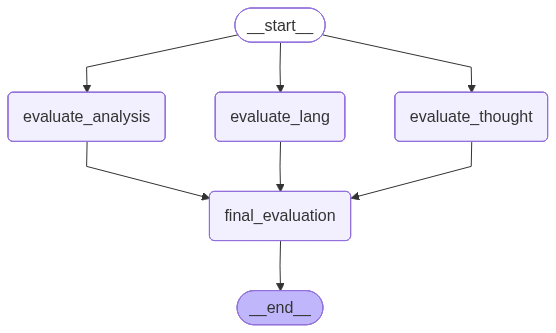

In [42]:
workflow

In [43]:
initial_state = {'essay': essay}

final_state = workflow.invoke(initial_state)

print(final_state)

{'essay': '\n    When I realized I was a punk rocker philosopher. One summer night, my friend took me to an underground hardcore punk rock show. It was inside a small abandoned church. After the show, I met and became a part of this small community. Many were lost and on a constant soul-search, and to my surprise, many, like myself, did not have a blue Mohawk or a nose piercing. Many were just ordinary people discussing Nietzsche, string theory, and governmental ideologies. Many were also artists creating promotional posters and inventive slogans for stickers. They were all people my age who could not afford to be part of a record label and did something extraordinary by playing in these abandoned churches, making their own CDs and making thousands of promotional buttons by hand. I realized then that punk rock is not about music nor is it a guy with a blue Mohawk screaming protests. Punk rock is an attitude, a mindset, and very much a culture. It is an antagonist to the conventional. I

In [45]:
print(final_state['clarity_feedback'])

The essay presents a unique and engaging perspective on the author's identity, blending the seemingly disparate worlds of punk rock and intellectualism. The author effectively uses personal anecdotes to illustrate their definition of punk rock as an attitude and culture rather than just a musical genre. The connection drawn between the punk rock community's resourcefulness and the author's aspirations for college is a strong point, highlighting a desire for a community that values critical thinking and self-empowerment. The essay could benefit from a slightly more structured flow between the introduction of the punk rock identity and the subsequent discussion of college aspirations. While the passion is evident, elaborating further on how specific aspects of college education will foster this 'punk rock philosopher' mindset would strengthen the argument.
